# Overview

- Load .bit file
- Basic loopback program calibration
    - original code from demo
    - time of flight cal
    - readout phase cal
    
- Load real qubit readout data (old data from ZCU111)
    
- Readout mock - averaged signal (as an example)
- Readout mock - singel-shot signal
    - single-shot with tunable guassian noise
    - iterate the single-shot experiment in python loop

In [1]:
# You should be on the ml branch of https://github.com/GiuseppeDiGuglielmo/qick
!git branch

  main
* ml-dev
  ml-dev-origin


In [2]:
!echo -n "git rev:  "; git rev-parse --short HEAD
!echo -n "git date: "; git log -1 --format=%cd

git rev:  28e9a41
git date: Fri May 17 23:19:33 2024 -0500


In [3]:
import subprocess
branch_name = subprocess.getoutput("git rev-parse --abbrev-ref HEAD")
print(branch_name)

ml-dev


# Load .bit file

In [4]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# Current directory
!pwd

/home/xilinx/jupyter_notebooks/qick_dev/qick_ml/readout_mock


In [6]:
# List custom bitstreams
!ls -l ../216/$branch_name/'00000000'

total 104776
drwxrwxr-x 2 xilinx xilinx     4096 May 19 13:07 OLD
-rw-rw-r-- 1 xilinx xilinx 34437473 May 19 20:54 qick_216_nn_w100.bit
-rw-rw-r-- 1 xilinx xilinx  1322232 May 19 20:54 qick_216_nn_w100.hwh
-rw-rw-r-- 1 xilinx xilinx 34437473 May 19 20:10 qick_216_nn_w200.bit
-rw-rw-r-- 1 xilinx xilinx  1322232 May 19 20:10 qick_216_nn_w200.hwh
-rw-rw-r-- 1 xilinx xilinx 34437473 May 19 14:42 qick_216_nn_w400.bit
-rw-rw-r-- 1 xilinx xilinx  1322232 May 19 14:42 qick_216_nn_w400.hwh


In [7]:
!ls -l ../216/$branch_name/'20240501'

total 4
drwxrwxr-x 2 xilinx xilinx 4096 May 19 13:07 OLD


In [8]:
# Choose custom bistreams

DATASET_DATE = '00000000'
#DATASET_DATE = '20240501'

# QICK
#CUSTOM_BIT = '../216/{}/qick_216_orig.bit'.format(branch_name)
#HAS_NN = 0

# # QICK + ILAs + syn/imp optimizations
# CUSTOM_BIT = '../216/{}/qick_216_ila.bit'.format(branch_name)
# HAS_NN = 0

# QICK + NN + syn/imp optimizations
WINDOW_SIZE = 400
CUSTOM_BIT = '../216/{}/{}/qick_216_nn_w{}.bit'.format(branch_name, DATASET_DATE, WINDOW_SIZE)
HAS_NN = True

# Save traces from NN
SAVE_NN_TRACES = True

# Configure channels
GEN_CH = 0
RO_CH = 0

In [9]:
# Load bitstream with custom overlay
if not 'CUSTOM_BIT' in locals():
    soc = QickSoc()
else:
    import os
    # Normalize path
    CUSTOM_BIT_FULL_PATH = os.path.normpath(os.getcwd() + '/' + CUSTOM_BIT)
    print('Custom bitsream:', CUSTOM_BIT_FULL_PATH)
    
    soc = QickSoc(bitfile=CUSTOM_BIT_FULL_PATH)

soccfg = soc
print(soccfg)

Custom bitsream: /home/xilinx/jupyter_notebooks/qick_dev/qick_ml/216/ml-dev/00000000/qick_216_nn_w400.bit

QICK configuration:

	Board: ZCU216

	Software version: 0.2.249
	Firmware timestamp: Sun May 19 11:47:12 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3

	2 readout channels:
	0:	axis_readout_v2 - controlled by PYNQ
		fs=2457.600 MHz, fabric=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 1024 decimated (3.333 us)
		triggered by output 0, pin 8, feedback to tProc input -1
		ADC tile 2, blk 0 is 0_226, on JHC7
	1:	axis_readout_v2 - controlled by PYNQ
		fs=2457.600 M

In [10]:
## Load bitstream with custom overlay
#soc = QickSoc()
## soc = QickSoc("qick_216_0821.bit")
## Since we're running locally on the QICK, we don't need a separate QickConfig object.
## If running remotely, you could generate a QickConfig from the QickSoc:
##     soccfg = QickConfig(soc.get_cfg())
## or save the config to file, and load it later:
##     with open("qick_config.json", "w") as f:
##         f.write(soc.dump_cfg())
##     soccfg = QickConfig("qick_config.json")
#soccfg = soc
#print(soccfg)

In [11]:
print('Loaded bitstream:', soccfg.bitfile_name)

Loaded bitstream: /home/xilinx/jupyter_notebooks/qick_dev/qick_ml/216/ml-dev/00000000/qick_216_nn_w400.bit


# NN Classifier Python API

In [12]:
from ctypes import *

def to_float(w):
    """
    Convert a 32b memory word to a floating-point number using ctypes.
    
    Args:
        w (int): The 32b word to convert.
        
    Returns:
        float: The converted floating-point number.
    """
    cp = pointer(c_int(w))
    fp = cast(cp, POINTER(c_float))
    return fp.contents.value

from pynq import MMIO

def reset_classifier(deep_reset = False, index_lo = 0, index_hi = 0):
    """
    Reset the classifier. Optionally perform a deep reset.
    
    Args:
        deep_reset (bool): If True, perform a deep reset by setting specific memory locations to zero. Default is False.
        index_lo (int): The lower index for the deep reset range. Default is 0.
        index_hi (int): The upper index for the deep reset range. Default is 0.
    """
    RESET_HI = 255
    RESET_LO = 0
    # Access the MMIO interface of the classifier
    mmio_nn = MMIO(soccfg.NN_0.mmio.base_addr, soccfg.NN_0.mmio.length)
    # This sends a "reset pulse" to the classifier
    mmio_nn.write(soccfg.NN_0.register_map.out_reset.address, RESET_HI)
    mmio_nn.write(soccfg.NN_0.register_map.out_reset.address, RESET_LO)
    if deep_reset:
        # Perform a deep reset by setting specific memory locations to zero
        # Warning: This may run for a long time; use only for debugging
        print('WARNING: Deep reset may run for some time... use only for debugging')
        entry_count = ((index_hi - index_lo) + 1) * 2
        for i in range(entry_count):
            soccfg.axi_blk_bram_ctrl_0.mmio.array[i] = 0

def configure_classifier(window_size, window_offset, scaling_factor, trigger_delay, debug = False):
    """
    Configure the classifier with the specified parameters.
    
    Args:
        window_size (int): The size of the window for classification.
        window_offset (int): The offset of the window for classification.
        scaling_factor (int): The scaling factor for classification.
        trigger_delay (int): The delay for triggering classification.
        debug (bool): If True, print debug information. Default is False.
    """
    if debug:
        # Print debug information about the classifier configuration
        print('INFO: classifier MMIO')
        print('INFO:   - base address:   @{:08x}'.format(soccfg.NN_0.mmio.base_addr))
        print('INFO:   - window_size:    @{} = {}'.format('??', window_size))
        print('INFO:   - window_offset:  @{:04x} = {}'.format(soccfg.NN_0.register_map.window_offset.address, window_offset))
        print('INFO:   - scaling_factor: @{:04x} = {}'.format(soccfg.NN_0.register_map.scaling_factor.address, scaling_factor))
        print('INFO:   - trigger_delay:  @{:04x} = {}'.format(soccfg.NN_0.register_map.trigger_delay.address, trigger_delay))
    # Access the MMIO interface of the classifier and configure it
    mmio_nn = MMIO(soccfg.NN_0.mmio.base_addr, soccfg.NN_0.mmio.length)
    mmio_nn.write(soccfg.NN_0.register_map.window_offset.address, window_offset)
    mmio_nn.write(soccfg.NN_0.register_map.scaling_factor.address, scaling_factor)
    mmio_nn.write(soccfg.NN_0.register_map.trigger_delay.address, trigger_delay)

def get_classifier_prediction_count():
    """
    Get how many predictions (pulses) have run through the classifier. This is 0 at the very beginning or if you reset the classifier.
    
    Returns:
        int: The number of predictions made by the classifier.
    """
    # Access the MMIO interface of the classifier
    mmio_nn = MMIO(soccfg.NN_0.mmio.base_addr, soccfg.NN_0.mmio.length)
    # Read and return the prediction count
    prediction_count = mmio_nn.read(soccfg.NN_0.register_map.out_offset.address)
    return prediction_count

def get_classifier_prediction(index = 0):
    """
    Get the classifier prediction for a specific index of the buffer.
    
    Args:
        index (int): The index of the prediction to retrieve. Default is 0.
        
    Returns:
        tuple: A tuple containing the ground state logit and the excited state logit.
    """
    WORD_SIZE_BYTE = 4
    WORD_COUNT_PER_PREDICTION = 2
    # Access the MMIO interface of the BRAM
    mmio_bram = MMIO(soccfg.axi_blk_bram_ctrl_0.base_address, soccfg.axi_blk_bram_ctrl_0.size)
    # Read the logits for the ground state and excited state
    ground_state_logit = mmio_bram.read(index * WORD_COUNT_PER_PREDICTION * WORD_SIZE_BYTE + 0)
    excited_state_logit = mmio_bram.read(index * WORD_COUNT_PER_PREDICTION * WORD_SIZE_BYTE + WORD_SIZE_BYTE)
    return ground_state_logit, excited_state_logit

def get_classifier_predictions(index_lo = 0, index_hi = 0):
    """
    Get a range of classifier predictions from the buffer.
    
    Args:
        index_lo (int): The lower index of the range of predictions to retrieve. Default is 0.
        index_hi (int): The upper index of the range of predictions to retrieve. Default is 0.
        
    Returns:
        list: A list of tuples, each containing the ground state logit and the excited state logit.
    """
    WORD_SIZE_BYTE = 4
    WORD_COUNT_PER_PREDICTION = 2
    # Access the MMIO interface of the BRAM
    mmio_bram = MMIO(soccfg.axi_blk_bram_ctrl_0.base_address, soccfg.axi_blk_bram_ctrl_0.size)
    # TODO: You can read the whole memory area rather than one element at a time and append
    predictions = []
    for index in range(index_lo, index_hi + 1):
        ground_state_logit = mmio_bram.read(index * WORD_COUNT_PER_PREDICTION * WORD_SIZE_BYTE + 0)
        excited_state_logit = mmio_bram.read(index * WORD_COUNT_PER_PREDICTION * WORD_SIZE_BYTE + WORD_SIZE_BYTE)
        predictions.append([ground_state_logit, excited_state_logit])
    return predictions

def print_classifier_buffer(index_lo, index_hi):
    """
    Print the classifier buffer for a range of indices.
    
    Args:
        index_lo (int): The lower index of the range to print.
        index_hi (int): The upper index of the range to print.
    """
    # Get the prediction count and buffer size
    prediction_count = get_classifier_prediction_count()
    buffer_size = len(soccfg.axi_blk_bram_ctrl_0.mmio.array)
    print('INFO: prediction count: {:6}'.format(prediction_count))
    print('INFO: buffer size     : {:6}'.format(buffer_size))
    print('INFO:')
    for i in range(index_lo, index_hi + 1):
        # Get the logits for each prediction and print them
        ground_state_logit, excited_state_logit = get_classifier_prediction(i)
        print('INFO: g [{:5d}] {:08x} ({}) {}'.format(i, ground_state_logit, to_float(ground_state_logit), '<<<' if prediction_count == i else ''))
        print('INFO: e [{:5d}] {:08x} ({}) {}'.format(i, excited_state_logit, to_float(excited_state_logit), '<<<' if prediction_count == i else ''))

# Basic loopback program calibration

## original code from demo

<!--- generator channel 6 : <-> Readout channel 0-->

In [13]:
print('Generator channel:', GEN_CH)
print('Readout channel  :', RO_CH)

Generator channel: 0
Readout channel  : 0


In [14]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [15]:
config={"res_ch": GEN_CH, #6, # --Fixed
        "ro_chs": [RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length": 770, #100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs": 1 #100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

In [16]:
prog = LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)

  0%|          | 0/1 [00:00<?, ?it/s]

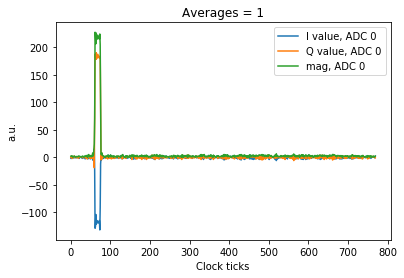

In [17]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
_ = plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

In [18]:
print(iq_list)

[[[-2.  1.  1. ...  0. -1.  2.]
  [ 0. -1.  2. ...  1. -1. -1.]]]


## Time of flight (tof) calibration

Find the mis-alignment between the DAC and ADC readout window for previous experiment

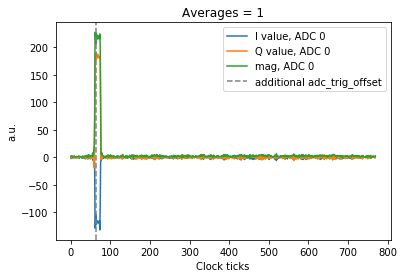

In [19]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))

###########################################################
### using this 'cursor' to find the additional adc_trig_offset
axvline(64, ls = '--', color = 'grey', label = 'additional adc_trig_offset')
###########################################################

plt.legend()

Adjust the `adc_trig_offset` in the `config` dict

- The DAC and ADC has different fabric freq
    - DAC: fabric=430.080 MHz
    - ADC: fabric=307.200 MHz
- the readout plot data is sampled at ADC fabric freq, but the adc_trig_offset is used in DAC fabric freq
    - so we need to convert the measured delay into input delay:
    - input delay = meausured delay * DAC fabric freq/ADC fabric freq //1

In [20]:
64*430.080/307.2

89.6

Now, the time of flight is calibrated

  0%|          | 0/1 [00:00<?, ?it/s]

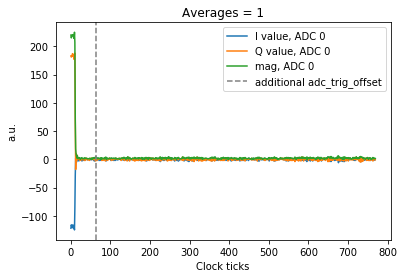

In [21]:
config={"res_ch": GEN_CH, #6, # --Fixed
        "ro_chs": [RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length": 770, #100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        ###########################################################
        ## pervious was 100
        "adc_trig_offset": 190, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks
        ###########################################################

        "soft_avgs": 1, #100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)


###################
# plot the result
###################

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))

axvline(63, ls = '--', color = 'grey', label = 'additional adc_trig_offset') ### using this 'cursor' to find the additional adc_trig_offset
plt.legend()

## Readout phase calibration
- code from qick_demos/05_PhaseCoherence_QickProgram.ipynb
- remeber to update the `adc_trig_offset` in the `config` file

In [22]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)

        self.r_rp=self.ch_page(self.cfg["res_ch"])     # get register page for res_ch
        self.r_gain=self.sreg(cfg["res_ch"], "gain")   #Get gain register for res_ch
        
        #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["ro_ch"], length=self.cfg["readout_length"],
                             freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])
        
        freq=self.freq2reg(cfg["pulse_freq"], gen_ch=cfg["res_ch"], ro_ch=cfg["ro_ch"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["pulse_gain"], 
                                 length=cfg["length"])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[self.cfg["ro_ch"]],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             t=0,
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

### First, sanity check that we can see the pulse we want to calibrate

In [23]:
config={"res_ch": GEN_CH, #6, # --Fixed
        "ro_ch": RO_CH, # --Fixed
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --Fixed
        "length":400, # [Clock ticks] 
        "readout_length":770, #200, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 190, # [Clock ticks]
        "reps":1, 
        "soft_avgs":1,
       }

prog = LoopbackProgram(soccfg, config)
(iq0,) = prog.acquire_decimated(soc,progress=False)

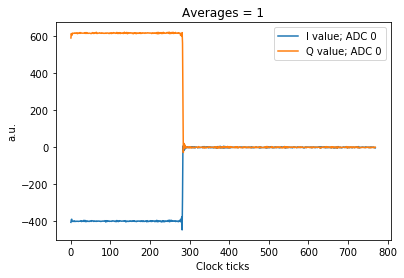

In [24]:
# Plot results.
plt.figure(1)
plt.plot(iq0[0], label="I value; ADC 0")
plt.plot(iq0[1], label="Q value; ADC 0")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

### Params 3 (We zoom in on the frequency area of interest and then print out the associated phase of interest)

In [25]:
config={"res_ch": GEN_CH, #6, # --Fixed
        "ro_ch": RO_CH, # --Fixed
        "relax_delay":1.0, # --Fixed
        "res_phase":0, # --Fixed
        "length":400, # [Clock ticks] 
        "readout_length":770, #200, # [Clock ticks]
        "pulse_gain":10000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 190, # [Clock ticks]
        "reps":1, 
        "soft_avgs":1,
       }


freq_readout = config["pulse_freq"]
freq_start = freq_readout - 0.002 ##[MHz]
freq_step = 0.000125  ##[MHz]
expts = 32

sweep_cfg={"start":freq_start, "step":freq_step, "expts":expts}

gpts=sweep_cfg["start"] + sweep_cfg["step"]*np.arange(sweep_cfg["expts"])
gpts

array([ 99.998   ,  99.998125,  99.99825 ,  99.998375,  99.9985  ,
        99.998625,  99.99875 ,  99.998875,  99.999   ,  99.999125,
        99.99925 ,  99.999375,  99.9995  ,  99.999625,  99.99975 ,
        99.999875, 100.      , 100.000125, 100.00025 , 100.000375,
       100.0005  , 100.000625, 100.00075 , 100.000875, 100.001   ,
       100.001125, 100.00125 , 100.001375, 100.0015  , 100.001625,
       100.00175 , 100.001875])

In [26]:
resultsi=[]
resultsq=[]
for g in gpts:
    time.sleep(0.1)
    config["pulse_freq"]=g
    prog =LoopbackProgram(soccfg, config)
    (iq0,) = prog.acquire_decimated(soc,progress=False)
    di0 = np.sum(iq0[0])/config["readout_length"]
    dq0 = np.sum(iq0[1])/config["readout_length"]
    resultsi.append(di0)
    resultsq.append(dq0)
resultsi=np.array(resultsi)
resultsq=np.array(resultsq)

Iteration i = 0, freq_i = 99.998000 MHz, phi_i = 125.736205 degrees
Iteration i = 1, freq_i = 99.998125 MHz, phi_i = 125.590730 degrees
Iteration i = 2, freq_i = 99.998250 MHz, phi_i = 125.414744 degrees
Iteration i = 3, freq_i = 99.998375 MHz, phi_i = 125.248454 degrees
Iteration i = 4, freq_i = 99.998500 MHz, phi_i = 125.083616 degrees
Iteration i = 5, freq_i = 99.998625 MHz, phi_i = 124.802825 degrees
Iteration i = 6, freq_i = 99.998750 MHz, phi_i = 124.659871 degrees
Iteration i = 7, freq_i = 99.998875 MHz, phi_i = 124.553438 degrees
Iteration i = 8, freq_i = 99.999000 MHz, phi_i = 124.371472 degrees
Iteration i = 9, freq_i = 99.999125 MHz, phi_i = 124.117420 degrees
Iteration i = 10, freq_i = 99.999250 MHz, phi_i = 123.939887 degrees
Iteration i = 11, freq_i = 99.999375 MHz, phi_i = 123.755238 degrees
Iteration i = 12, freq_i = 99.999500 MHz, phi_i = 123.572060 degrees
Iteration i = 13, freq_i = 99.999625 MHz, phi_i = 123.403788 degrees
Iteration i = 14, freq_i = 99.999750 MHz, ph

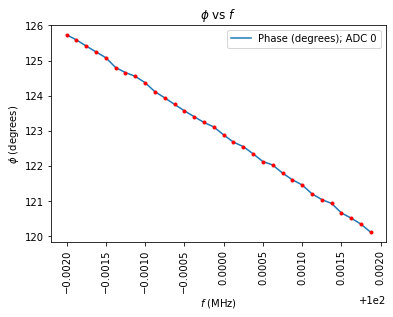

In [27]:
# Plot results.
sig = resultsi + 1j * resultsq
amp_array = np.abs(sig)
phase_array = np.angle(sig,deg=True)
for x in range(0,len(phase_array)):
    if phase_array[x] <0:
        phase_array[x] = phase_array[x] +360
    print("Iteration i = %d, freq_i = %f MHz, phi_i = %f degrees" %(x,gpts[x], phase_array[x]))
plt.figure(1)
# plt.plot(gpts, resultsi,label="I value; ADC 0")
# plt.plot(gpts, resultsq,label="Q value; ADC 0")
# plt.plot(gpts, amp_array,label="Amplitude (DAC units); ADC 0")
plt.plot(gpts, phase_array, label="Phase (degrees); ADC 0")
plt.plot(gpts,phase_array, marker='.', linestyle="None",color="Red")
plt.xticks(rotation=90)
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.legend()
# plt.savefig("images/Phase_sweep.pdf", dpi=350)

At 100 MHz, Phase = 122.88706795739598 degree


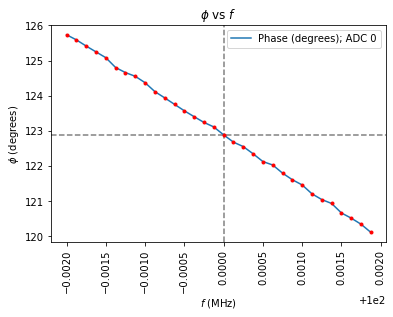

In [28]:
target_freq = freq_readout ### put the actual readout freq here

freq_index = np.where(gpts == target_freq)[0][0]
phase_cal = phase_array[freq_index]

print(f'At {target_freq} MHz, Phase = {phase_cal} degree')

plt.axvline(gpts[freq_index], ls = '--', color = 'grey')
plt.axhline(phase_array[freq_index], ls = '--', color = 'grey')


plt.plot(gpts, phase_array, label="Phase (degrees); ADC 0")
plt.plot(gpts,phase_array, marker='.', linestyle="None",color="Red")
plt.xticks(rotation=90)
plt.title(r"$\phi$ vs $f$")
plt.ylabel(r"$\phi$ (degrees)")
plt.xlabel(r"$f$ (MHz)")
plt.legend()

### re-run the loopback program with compensate phase
- Now the signal is only on I component

In [29]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [30]:
config={"res_ch": GEN_CH, #6, # --Fixed
        "ro_chs": [RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase": phase_cal, # updated readout phase
        "pulse_style": "const", # --Fixed
        
        "length":20, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":770, #100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 190, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs": 1 #100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)

  0%|          | 0/1 [00:00<?, ?it/s]

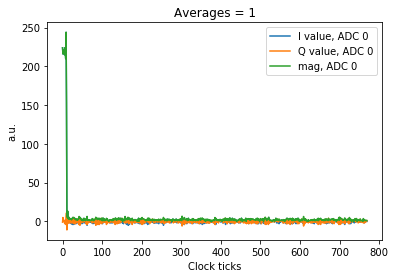

In [31]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

# Load real qubit readout data (old data from ZCU111)


g_data[p1,p2,p3] for ground state readout

e_data[p1,p2,p3] for excited state readout
- p1: index for shot
- p2: index for I/Q
- p3: index for time, step of clock cycle = 2.6ns

In [32]:
with open('readout_data.npy', 'rb') as f:
    g_data = np.load(f)
    e_data = np.load(f)

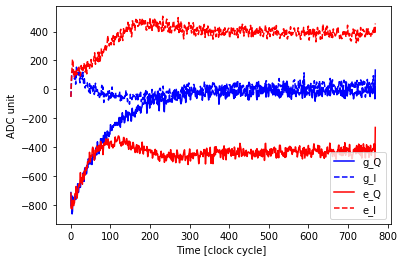

In [33]:
# avargaed trace
plt.plot(g_data[:,1,:].mean(axis = 0), label = 'g_Q', color = 'b')
plt.plot(g_data[:,0,:].mean(axis = 0), label = 'g_I', color = 'b', ls = '--')

plt.plot(e_data[:,1,:].mean(axis = 0), label = 'e_Q', color = 'r')
plt.plot(e_data[:,0,:].mean(axis = 0), label = 'e_I', color = 'r', ls = '--')

plt.ylabel('ADC unit')
plt.xlabel('Time [clock cycle] ')
plt.legend()

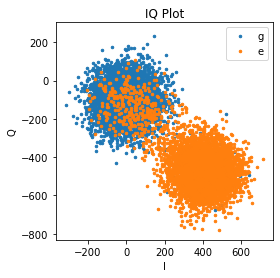

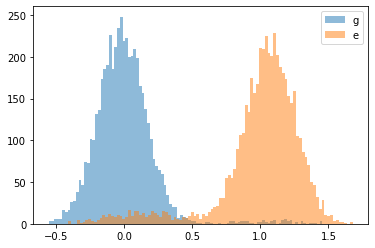

max fidelity =  0.9148000000000001

 rough estimation of n_th


1.74

In [34]:
# IQ plot
I_g = g_data[:,0,:].mean(axis = 1)
Q_g = g_data[:,1,:].mean(axis = 1)

I_e = e_data[:,0,:].mean(axis = 1)
Q_e = e_data[:,1,:].mean(axis = 1)

plt.title('IQ Plot')
plt.plot(I_g, Q_g, '.',label = 'g',markersize = 5)
plt.plot(I_e, Q_e, '.',label = 'e',markersize = 5)
plt.xlabel('I')
plt.ylabel('Q')
plt.legend()
plt.axis('square')
plt.show()

vec_I = mean(I_e) - mean(I_g)
vec_Q = mean(Q_e) - mean(Q_g)

gstate = (I_g - mean(I_g))*vec_I + (Q_g - mean(Q_g))*vec_Q
estate = (I_e - mean(I_g))*vec_I + (Q_e - mean(Q_g))*vec_Q
gstate = gstate / abs(vec_I+1j*vec_Q)**2
estate = estate / abs(vec_I+1j*vec_Q)**2
plt.hist(gstate,bins = 100,label = 'g',alpha = 0.5)
plt.hist(estate,bins = 100,label = 'e',alpha = 0.5)
plt.legend()
plt.show()

th_min = min(gstate)
th_max = max(estate)
th_list = np.linspace(th_min,th_max,1000)

fidelity = [(sum(gstate<th)+sum(estate>th))/np.shape(gstate)[0]/2 for i,th in enumerate(th_list)]
print('max fidelity = ',max(fidelity)*2-1)

print('\n rough estimation of n_th')
100*sum(gstate>th_list[argmax(fidelity)])/len(gstate)

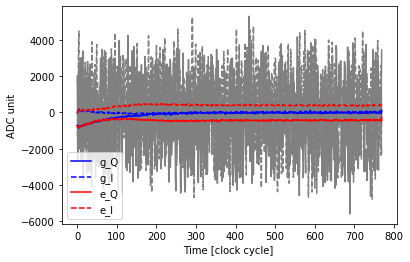

In [35]:
# signal shot
shot_index = 0

plt.plot(g_data[shot_index,1,:], color = 'grey')
plt.plot(g_data[shot_index,0,:], color = 'grey', ls = '--')

plt.plot(e_data[shot_index,1,:], color = 'grey')
plt.plot(e_data[shot_index,0,:], color = 'grey', ls = '--')

plt.plot(g_data[:,1,:].mean(axis = 0), label = 'g_Q', color = 'b')
plt.plot(g_data[:,0,:].mean(axis = 0), label = 'g_I', color = 'b', ls = '--')

plt.plot(e_data[:,1,:].mean(axis = 0), label = 'e_Q', color = 'r')
plt.plot(e_data[:,0,:].mean(axis = 0), label = 'e_I', color = 'r', ls = '--')

plt.ylabel('ADC unit')
plt.xlabel('Time [clock cycle] ')
plt.legend()
# xlim(0,100)

# readout mock - averaged signal (as an example)

- to get the wf for DAC, we need to resample the data due to 
    - the frequency on ADC and DAC are different
    - the wf need to sample in dds frequency

            DAC tile 3, blk 2, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
            ADC tile 2, blk 0, 32-bit DDS, fabric=307.200 MHz, fs=2457.600 MHz

real readout data length = 770 clock cycle


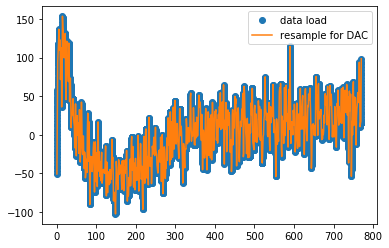

In [36]:
#### load real qubit readout data
data_len = len(g_data[:,0,:].mean(axis = 0))
print(f'real readout data length = {data_len} clock cycle')


### we need to resample the data based on DAC freq
t_ns = data_len*1000/307.2
dac_len = int((t_ns/1000*6881.28)//16*16)

g_I_load = g_data[:,0,:].mean(axis = 0)
g_Q_load = g_data[:,1,:].mean(axis = 0)
e_I_load = e_data[:,0,:].mean(axis = 0)
e_Q_load = e_data[:,1,:].mean(axis = 0)

### resample the waveform
xp = np.linspace(1,data_len,data_len) ### ADC side time array
x = np.linspace(1,data_len,dac_len)   ### DAC side time array

g_I = np.interp(x, xp, g_I_load)
g_Q = np.interp(x, xp, g_Q_load)
e_I = np.interp(x, xp, e_I_load)
e_Q = np.interp(x, xp, e_Q_load)


### plot one component of the resampled waveform
plot(x,g_I, 'o' , label = 'data load')
plot(xp,g_I_load, label = 'resample for DAC')
legend()
show()

In [37]:
DAC_gain = 1 ### tune this parameter to match the ADC level with the training data

class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]
        
        
        ########################
        ### add g/e waveform ###
        ########################
#         self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_I, qdata = DAC_gain*g_Q)
#         self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_I, qdata = DAC_gain*e_Q)
        self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_Q, qdata = DAC_gain*g_I)
        self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_Q, qdata = DAC_gain*e_I)

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
            
        ########################
        ### add g/e waveform ###
        ########################   
        elif style == "g_state":
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="g_state")
        elif style == "e_state":
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="e_state")

        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [38]:
### calculate the DAC output range

gencfg = soccfg['gens'][GEN_CH]
max_amp = gencfg['maxv']*gencfg['maxv_scale']
print('max_amp = ',max_amp)

max_amp =  32766.0


In [39]:
DAC_phase = -90
readout_phase = phase_cal + DAC_phase

config={"res_ch": GEN_CH, #6, # --Fixed
        "ro_chs": [RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase": readout_phase, # updated readout phase
        "pulse_style": "e_state", # --Fixed,"const"; "g_state"; "e_state"; "arb"
        
        "sigma": 30, # [Clock ticks]
        
        "length": 100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":data_len, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain": 30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 190, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)

  0%|          | 0/1 [00:00<?, ?it/s]

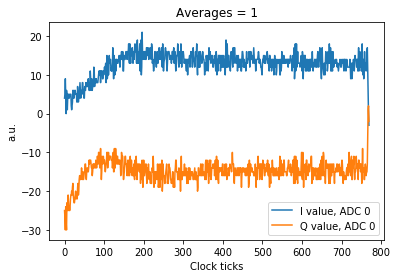

In [40]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
#     plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

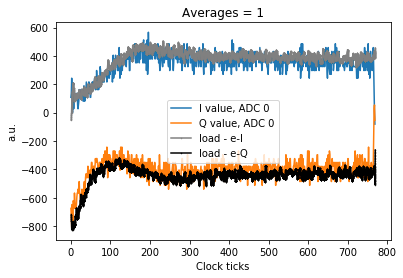

In [41]:
ADC_fake_gain = 27 ### tune this parameter to match the ADC level with the training data


for ii, iq in enumerate(iq_list):
    plt.plot(iq[0]*ADC_fake_gain, markersize=0.5, color = 'C0' , label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1]*ADC_fake_gain, markersize=0.5, color = 'C1' ,label="Q value, ADC %d"%(config['ro_chs'][ii]))
plt.plot(x,e_I, '-o', markersize=0.5, color = 'grey', label = 'load - e-I')
plt.plot(x,e_Q, '-o', markersize=0.5, color = 'black', label = 'load - e-Q')


plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

# Readout mock - single-shot signal

## single-shot with tunable gaussian noise

In [42]:
MEAN_ENABLED = False
TRACE_ID = 0

readout data length = 770 clock cycle


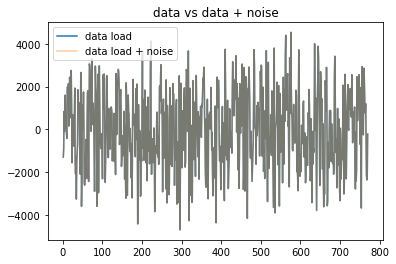

In [43]:
#### load real qubit readout data
data_len = len(g_data[:,0,:].mean(axis = 0))
print(f'readout data length = {data_len} clock cycle')

### we need to resample the data based on DAC freq
t_ns = data_len*1000/307.2
dac_len = int((t_ns/1000*6881.28)//16*16)

if MEAN_ENABLED:
    g_I_load = g_data[:,0,:].mean(axis = 0)
    g_Q_load = g_data[:,1,:].mean(axis = 0)
    e_I_load = e_data[:,0,:].mean(axis = 0)
    e_Q_load = e_data[:,1,:].mean(axis = 0)
else:
    g_I_load = g_data[TRACE_ID,0,:]
    g_Q_load = g_data[TRACE_ID,1,:]
    e_I_load = e_data[TRACE_ID,0,:]
    e_Q_load = e_data[TRACE_ID,1,:]

### set noise parameter
add_noise = False
noise_scale = 400

if add_noise and MEAN_ENABLED:
    g_I_add_noise = g_I_load + np.random.normal(0, noise_scale, size = g_I_load.shape[0])
    g_Q_add_noise = g_Q_load + np.random.normal(0, noise_scale, size = g_Q_load.shape[0])
    e_I_add_noise = e_I_load + np.random.normal(0, noise_scale, size = e_I_load.shape[0])
    e_Q_add_noise = e_Q_load + np.random.normal(0, noise_scale, size = e_Q_load.shape[0])
else:
    g_I_add_noise = g_I_load
    g_Q_add_noise = g_Q_load
    e_I_add_noise = e_I_load
    e_Q_add_noise = e_Q_load
    
plot(xp,g_I_load , label = 'data load')
plot(xp,g_I_add_noise, label = 'data load + noise', alpha = 0.4)
title('data vs data + noise')
legend()
show()
### resample the waveform
xp = np.linspace(1,data_len,data_len)
x = np.linspace(1,data_len,dac_len)
    
g_I = np.interp(x, xp, g_I_load)
g_Q = np.interp(x, xp, g_Q_load)
e_I = np.interp(x, xp, e_I_load)
e_Q = np.interp(x, xp, e_Q_load)

if add_noise and MEAN_ENABLED:
    g_I = np.interp(x, xp, g_I_add_noise)
    g_Q = np.interp(x, xp, g_Q_add_noise)
    e_I = np.interp(x, xp, e_I_add_noise)
    e_Q = np.interp(x, xp, e_Q_add_noise)
    
    title('Performance of the resampling')
    plot(x, g_I, 'o', label = 'after resampling')
    plot(xp, g_I_add_noise, label = 'before resampling')
    legend()
    show()

In [44]:
DAC_gain = 1 ### tune this parameter to match the ADC level with the training data

class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]
        
        
        ########################
        ### add g/e waveform ###
        ########################
#         self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_I, qdata = DAC_gain*g_Q)
#         self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_I, qdata = DAC_gain*e_Q)
        self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_Q, qdata = DAC_gain*g_I)
        self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_Q, qdata = DAC_gain*e_I)

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
            
        ########################
        ### add g/e waveform ###
        ########################   
        elif style == "g_state":
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="g_state")
        elif style == "e_state":
            self.set_pulse_registers(ch=res_ch, style="arb", waveform="e_state")

        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))

In [45]:
### calculate the DAC output range
gencfg = soccfg['gens'][GEN_CH]
max_amp = gencfg['maxv']*gencfg['maxv_scale']
print('max_amp = ',max_amp)

max_amp =  32766.0


In [46]:
##########################################################
##########################################################
##########################################################
# If you are running Vivado ILAs, it is time to arm them #
##########################################################
##########################################################
##########################################################

In [47]:
# How many readouts so far?
get_classifier_prediction_count()

37

In [48]:
%%time
if HAS_NN:
    WINDOW_OFFSET = 150
    SCALING_FACTOR = 1
    TRIGGER_DELAY = 0
    
    reset_classifier()
    configure_classifier(WINDOW_SIZE, WINDOW_OFFSET, SCALING_FACTOR, TRIGGER_DELAY, True)

INFO: classifier MMIO
INFO:   - base address:   @a0020000
INFO:   - window_size:    @?? = 400
INFO:   - window_offset:  @0010 = 150
INFO:   - scaling_factor: @0018 = 1
INFO:   - trigger_delay:  @0020 = 0
CPU times: user 474 ms, sys: 36 ms, total: 510 ms
Wall time: 495 ms


In [49]:
# 0 readouts after reset
get_classifier_prediction_count()

0

In [50]:
DAC_phase = -90
readout_phase = phase_cal + DAC_phase

config={"res_ch": GEN_CH, #6, # --Fixed
        "ro_chs": [RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase": readout_phase, # updated readout phase
        
        "pulse_style": "e_state", # --Fixed,"const"; "g_state"; "e_state"; "arb"
        #"pulse_style": "g_state", # --Fixed,"const"; "g_state"; "e_state"; "arb"
        
        "sigma": 30, # [Clock ticks]
        
        "length": 100, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":data_len, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain": 30000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 190, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog = LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True)#, debug=False)

  0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
iq_list.shape

(1, 2, 770)

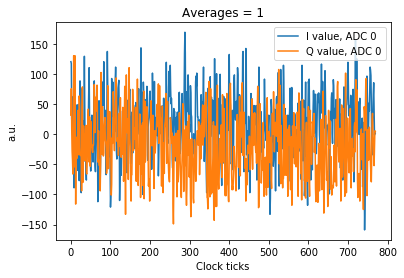

In [52]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
#     plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

In [53]:
print('iq_list shape (I/Q):', iq_list[0].shape)
print('data_len:', data_len)

# Shows I and Q sequence
iq = iq_list[0]
iq_sequence = [list(item) for item in zip(*iq)]
iq_sequence = [int(item) for sublist in iq_sequence for item in sublist]
print(iq_sequence)

iq_list shape (I/Q): (2, 770)
data_len: 770
[121, 32, 118, 76, 25, 10, 49, -28, 37, -43, -21, -66, 63, 22, 34, 131, -89, -10, 29, -54, 14, 131, -84, 34, 39, -116, 21, -29, -49, -5, 49, -40, 38, -25, -60, -1, -14, 40, 50, -5, -12, -34, -77, 64, 0, 46, 89, -21, 48, -35, -28, -31, -97, -39, -16, -94, 76, 25, -45, 79, -45, -80, 22, -56, -45, 14, 18, -31, 130, -7, 44, 0, -44, -44, -21, 8, -58, 15, -76, -64, -6, -66, 7, -40, -18, -20, 3, 24, 29, 42, 66, -30, 111, -46, 44, 29, -39, -25, -46, -53, -61, 22, -41, 9, 9, -21, 32, -18, 21, -27, -31, -30, -46, -18, -18, -18, 48, 16, 89, 83, 22, 42, -52, 3, -62, 60, -24, 62, 3, 39, 13, 60, 61, 82, 14, 30, -112, -46, -91, -10, 32, 6, 56, -47, -8, -52, -47, -42, -78, -94, -34, -49, 7, 103, -21, 38, 5, -33, 51, 45, 87, 46, 54, 9, 49, -36, 121, -31, 67, 10, 5, 20, 37, 28, 40, -8, -18, -13, -67, -24, -26, -65, 57, -56, 138, 4, 80, 81, -38, 24, -38, -57, -30, -23, -2, 26, 22, 38, -54, 27, -121, 1, -101, -41, -11, -101, 93, -83, 54, -6, 30, -15, 87, 6, 24, 

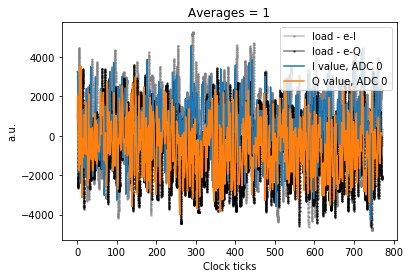

In [54]:
ADC_fake_gain = 27 ### tune this parameter to match the ADC level with the training data

plt.plot(x,e_I, '-o', markersize=1.5, color = 'grey', label = 'load - e-I', alpha = 0.5)
plt.plot(x,e_Q, '-o', markersize=1.5, color = 'black', label = 'load - e-Q', alpha = 0.5)

for ii, iq in enumerate(iq_list):
    plt.plot(iq[0]*ADC_fake_gain, markersize=0.5, color = 'C0' , label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1]*ADC_fake_gain, markersize=0.5, color = 'C1' ,label="Q value, ADC %d"%(config['ro_chs'][ii]))

plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

## Collect NN results

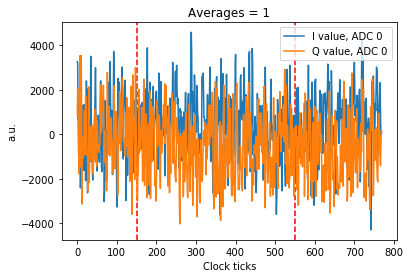

In [55]:
###########################################################
axvline(WINDOW_OFFSET, ls = '--', color = 'red')
axvline(WINDOW_OFFSET+WINDOW_SIZE, ls = '--', color = 'red')
###########################################################

#plt.plot(x,e_I, '-o', markersize=1.5, color = 'grey', label = 'load - e-I', alpha = 0.5)
#plt.plot(x,e_Q, '-o', markersize=1.5, color = 'black', label = 'load - e-Q', alpha = 0.5)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0]*ADC_fake_gain, markersize=0.5, color = 'C0' , label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1]*ADC_fake_gain, markersize=0.5, color = 'C1' ,label="Q value, ADC %d"%(config['ro_chs'][ii]))

plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

In [56]:
# Save trace.
iq_nn = iq_list[0,:,285:385]*ADC_fake_gain

In [57]:
import struct
def float_to_hex32(f):
    return format(struct.unpack('!I', struct.pack('!f', f))[0], '08x')

def int_to_twos_complement_hex32(n):
    # If the number is negative, get its two's complement
    if n < 0:
        n = (1 << 32) + n  # "Wrap around" to get 32-bit two's complement
    return format(n, '08x')

# Shows I and Q sequence
iq_sequence_nn = [list(item) for item in zip(*iq_nn)]
iq_sequence_nn = [int(item) for sublist in iq_sequence_nn for item in sublist]

# Float value as hex
#hex_iq_sequence_flt = [float_to_hex32(num) for num in iq_sequence]

# Float -> Int value as hex
#hex_iq_sequence_dec = [int_to_twos_complement_hex32(int(i)) for i in iq_sequence]

print('Sequence length:', len(iq_sequence_nn))
print('I (lo, data[15:0])')
print(iq_nn[0])
print('Q (hi, data[31:16])')
print(iq_nn[1])

print(iq_sequence_nn)

#print(hex_iq_sequence_flt)
#print(hex_iq_sequence_dec)

#for i in range(0,len(iq_sequence),2):
#    print("I {:4.0f} {} {}".format(iq_sequence[i], hex_iq_sequence_flt[i], hex_iq_sequence_dec[i]))
#    print("Q {:4.0f} {} {}".format(iq_sequence[i+1], hex_iq_sequence_flt[i+1], hex_iq_sequence_dec[i+1]))

Sequence length: 200
I (lo, data[15:0])
[  675.  1809.  3645.  4590.  3672.   405.  -594.   945.  1917.  1647.
  1026.  2673.  2160.  -324.   486.   351.   108.  2187.  1863.   891.
   783.  -432.  -702.  -675.  -864.    27.   -27.  -972. -1377.  -135.
  2349.  2619.  2160.  2754.  1917.   783.   783.   216.  -216.    27.
   648.   621.     0.  1080.  1782.   378.   216.  1458.  1134.  1755.
  3024.   621. -1215.  -486.   378.   729.  -135. -1701. -2619. -1755.
  -378.  1026.  2079.  1323.   783.   864.  2079.  2592.  -108.   108.
  1674.   459.   702.  1539.   891. -1404. -3618.   729.  3402.     0.
   675.  2322.  1944.  2727.  1647. -1053. -1944. -1404.   972.  1620.
    27.  1026.  2700.  1242. -1296. -1674. -2295.  -459.  1350. -1296.]
Q (hi, data[31:16])
[-2565. -1269.   189. -1404.  -162.   378. -2592. -3186. -2403.  -297.
   567.  -945.   729.   864. -1917.  -999.  -243. -2727. -3699. -1782.
  -189.  -621. -1053. -1215. -2862. -3078. -1134.  -243.  -324. -1296.
 -2106. -2106. -

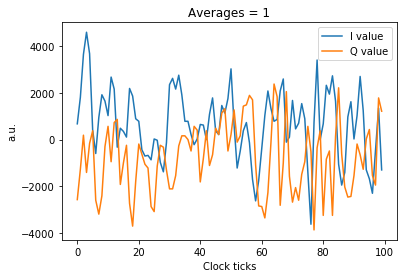

In [58]:
plt.plot(iq_nn[0], markersize=0.5, color = 'C0', label="I value")
plt.plot(iq_nn[1], markersize=0.5, color = 'C1', label="Q value")

# x = list(range(0, 101, 20))
# x_offset = list(range(285, 386, 20))
# plt.xticks(x, x_offset)

plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()

In [59]:
#
# ATTENTION: if the cell fails, please make sure that
#            the base_address matches the associated
#            value in the address editor of the Vivado
#            project.
# 
if HAS_NN:    
    from ctypes import *
    def to_float(i):
        cp = pointer(c_int(i))
        fp = cast(cp, POINTER(c_float))
        return fp.contents.value
    
    ground_state_logit, excited_state_logit = get_classifier_prediction()

    if config['pulse_style'] == 'g_state':
        print('Expected:   ground state')
    else:
        print('Expected:   excited state')
    
    if (to_float(ground_state_logit) > to_float(excited_state_logit)):
        print('Prediction: ground state', end='')
        if config['pulse_style'] == 'g_state':
            print(', CORRECT')
        else:
            print(', WRONG')
    else:
        print('Prediction: excited state', end='')
        if config['pulse_style'] == 'e_state':
            print(', CORRECT')
        else:
            print(', WRONG')
    print('')
    print('Logit values as int: [', ground_state_logit, ',', excited_state_logit, ']')
    print('Logit values as hex: [', hex(ground_state_logit), ',', hex(excited_state_logit), ']')
    print('Logit values as flt: [', to_float(ground_state_logit), ',', to_float(excited_state_logit), ']')
else:
    print('No NN in this bitstream!')

Expected:   excited state
Prediction: ground state, WRONG

Logit values as int: [ 1069924352 , 3217514496 ]
Logit values as hex: [ 0x3fc5c000 , 0xbfc76000 ]
Logit values as flt: [ 1.544921875 , -1.5576171875 ]


In [60]:
print_classifier_buffer(index_lo = 0, index_hi = 7)

INFO: prediction count:      1
INFO: buffer size     :  32768
INFO:
INFO: g [    0] 3fc5c000 (1.544921875) 
INFO: e [    0] bfc76000 (-1.5576171875) 
INFO: g [    1] 3fe0c000 (1.755859375) <<<
INFO: e [    1] bfdcc000 (-1.724609375) <<<
INFO: g [    2] 3fe0c000 (1.755859375) 
INFO: e [    2] bfdcc000 (-1.724609375) 
INFO: g [    3] 3fe0c000 (1.755859375) 
INFO: e [    3] bfdcc000 (-1.724609375) 
INFO: g [    4] 3fe0c000 (1.755859375) 
INFO: e [    4] bfdcc000 (-1.724609375) 
INFO: g [    5] 3fe0c000 (1.755859375) 
INFO: e [    5] bfdcc000 (-1.724609375) 
INFO: g [    6] 3fe0c000 (1.755859375) 
INFO: e [    6] bfdcc000 (-1.724609375) 
INFO: g [    7] 3fe0c000 (1.755859375) 
INFO: e [    7] bfdcc000 (-1.724609375) 


In [61]:
#reset_classifier(deep_reset = False, index_lo = 0, index_hi = 0)

In [62]:
#print_classifier_buffer(0,7)

## Many runs and collect results

In [63]:
# How many readouts so far?
get_classifier_prediction_count()

1

In [64]:
%%time
if HAS_NN:    
    reset_classifier()

CPU times: user 151 ms, sys: 3.94 ms, total: 155 ms
Wall time: 152 ms


In [65]:
# 0 readouts after reset
get_classifier_prediction_count()

0

In [66]:
VERBOSE = False

In [67]:
%%time
import pandas as pd

from ctypes import *

errors = {'g_state' : 0, 'e_state' : 0}

def to_float(i):
    cp = pointer(c_int(i))
    fp = cast(cp, POINTER(c_float))
    return fp.contents.value

### load real qubit readout data
data_len = len(g_data[0,0,:])
if VERBOSE:
    print(f'readout data length = {data_len} clock cycle')

### how many traces we have?
trace_count = {'g_state' : len(g_data[:,0,:]), 'e_state' : len(e_data[:,0,:])}

if VERBOSE:
    print('ground traces count  = {}'.format(trace_count['g_state']))
    print('excited traces count = {}'.format(trace_count['e_state']))

### we need to resample the data based on DAC freq
t_ns = data_len*1000/307.2
dac_len = int((t_ns/1000*6881.28)//16*16)


if HAS_NN:

    ################
    # Configure NN #
    ################
    reset_classifier()
    configure_classifier(WINDOW_SIZE, WINDOW_OFFSET, scaling_factor=ADC_fake_gain, trigger_delay=5)
    ################

    for state_id, pulse_style in enumerate(['g_state', 'e_state']):
        
        #n_traces = trace_count[pulse_style]
        n_traces = 250
        
        if not VERBOSE:
            print('-' * 80)
            print('Sending {} {} traces to the NN'.format(n_traces, pulse_style))
            print('Legend:')
            print('  . = CORRECT classification')
            print('  * = WRONG   classification')

        DAC_phase = -90
        readout_phase = phase_cal + DAC_phase

        config={"res_ch": GEN_CH, #6, # --Fixed
                "ro_chs": [RO_CH], # --Fixed
                "reps":1, # --Fixed
                "relax_delay":1.0, # --us
                "res_phase": readout_phase, # updated readout phase

                "pulse_style": pulse_style, # --Fixed,"const"; "g_state"; "e_state"; "arb"

                "sigma": 30, # [Clock ticks]

                "length": 100, # [Clock ticks]
                # Try varying length from 10-100 clock ticks

                "readout_length":data_len, # [Clock ticks]
                # Try varying readout_length from 50-1000 clock ticks

                "pulse_gain": 30000, # [DAC units]
                # Try varying pulse_gain from 500 to 30000 DAC units

                "pulse_freq": 100, # [MHz]
                # In this program the signal is up and downconverted digitally so you won't see any frequency
                # components in the I/Q traces below. But since the signal gain depends on frequency, 
                # if you lower pulse_freq you will see an increased gain.

                "adc_trig_offset": 190, # [Clock ticks]
                # Try varying adc_trig_offset from 100 to 220 clock ticks

                "soft_avgs": n_traces
                # Try varying soft_avgs from 1 to 200 averages

               }        
        
        _trace_id = 0
        g_I_load = g_data[_trace_id,0,:]
        g_Q_load = g_data[_trace_id,1,:]
        e_I_load = e_data[_trace_id,0,:]
        e_Q_load = e_data[_trace_id,1,:]

        g_I = np.interp(x, xp, g_I_load)
        g_Q = np.interp(x, xp, g_Q_load)
        e_I = np.interp(x, xp, e_I_load)
        e_Q = np.interp(x, xp, e_Q_load)

        DAC_gain = 1 ### tune this parameter to match the ADC level with the training data

        class LoopbackProgram(AveragerProgram):
            def initialize(self):
                cfg = self.cfg   
                res_ch = cfg["res_ch"]

                # set the nyquist zone
                self.declare_gen(ch=cfg["res_ch"], nqz=1)

                # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
                for ch in cfg["ro_chs"]:
                    self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                         freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

                # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
                freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
                phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
                gain = cfg["pulse_gain"]
                self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

                style=self.cfg["pulse_style"]


                ########################
                ### add g/e waveform ###
                ########################
                #self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_I, qdata = DAC_gain*g_Q)
                #self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_I, qdata = DAC_gain*e_Q)
                self.add_pulse(ch=cfg["res_ch"], name = 'g_state', idata = DAC_gain*g_Q, qdata = DAC_gain*g_I)
                self.add_pulse(ch=cfg["res_ch"], name = 'e_state', idata = DAC_gain*e_Q, qdata = DAC_gain*e_I)

                if style in ["flat_top","arb"]:
                    sigma = cfg["sigma"]
                    self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)

                if style == "const":
                    self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
                elif style == "flat_top":
                    # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
                    self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
                elif style == "arb":
                    self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")

                ########################
                ### add g/e waveform ###
                ########################   
                elif style == "g_state":
                    self.set_pulse_registers(ch=res_ch, style="arb", waveform="g_state")
                elif style == "e_state":
                    self.set_pulse_registers(ch=res_ch, style="arb", waveform="e_state")


                self.synci(200)  # give processor some time to configure pulses

            def body(self):
                # fire the pulse
                # trigger all declared ADCs
                # pulse PMOD0_0 for a scope trigger
                # pause the tProc until readout is done
                # increment the time counter to give some time before the next measurement
                # (the syncdelay also lets the tProc get back ahead of the clock)
                self.measure(pulse_ch=self.cfg["res_ch"], 
                             adcs=self.ro_chs,
                             pins=[0], 
                             adc_trig_offset=self.cfg["adc_trig_offset"],
                             wait=True,
                             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

        # calculate the DAC output range
        gencfg = soccfg['gens'][GEN_CH]
        max_amp = gencfg['maxv']*gencfg['maxv_scale']
        #print('max_amp = ',max_amp)

        # Run pulse generation and readout
        # It also runs the NN
        prog = LoopbackProgram(soccfg, config)
        iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=VERBOSE)#, debug=False)

        ###################
        # Read NN results #
        ###################
        #ground_state_logit, excited_state_logit = get_classifier_prediction(state_id * n_traces + trace_id)
        #predictions = get_classifier_predictions(index_lo = 0, index_hi = state_id * n_traces + trace_id)
        ###################
    
        #print_classifier_buffer(index_lo=0, index_hi=100)         
            
        for trace_id in range(n_traces):
            
            ground_state_logit, excited_state_logit = get_classifier_prediction(state_id * n_traces + trace_id)
            
            # Console printous
            if VERBOSE:
                if pulse_style == 'g_state':
                    print('Expected:   ground state')
                else:
                    print('Expected:   excited state')

                print('{} {}'.format(to_float(ground_state_logit), to_float(excited_state_logit)))
                if (to_float(ground_state_logit) > to_float(excited_state_logit)):
                    print('Prediction: ground state', end='')
                    if pulse_style == 'g_state':
                        print(', CORRECT')
                    else:
                        print(', WRONG')
                else:
                    print('Prediction: excited state', end='')
                    if pulse_style == 'e_state':
                        print(', CORRECT')
                    else:
                        print(', WRONG')
                print('')
                print('Logit values as int: [', ground_state_logit, ',', excited_state_logit, ']')
                print('Logit values as hex: [', hex(ground_state_logit), ',', hex(excited_state_logit), ']')
                print('Logit values as flt: [', to_float(ground_state_logit), ',', to_float(excited_state_logit), ']')

            # Error count
            if (to_float(ground_state_logit) > to_float(excited_state_logit)):
                if pulse_style != 'g_state':
                    errors[pulse_style] = errors[pulse_style] + 1
            else:
                if pulse_style != 'e_state':
                    errors[pulse_style] = errors[pulse_style] + 1

            if not VERBOSE:
                if (trace_id % 25) == 0:
                    print('{:s}{:5d}'.format(pulse_style, trace_id), end=' ')
                if (to_float(ground_state_logit) > to_float(excited_state_logit)):
                    if pulse_style != 'g_state':
                        print('*', end='')
                    else:
                        print('.', end='')
                else:
                    if pulse_style != 'e_state':
                        print('*', end='')
                    else:
                        print('.', end='')
                if ((trace_id+1) % 25) == 0:
                    print('')

else:
    print('No NN in this bitstream!')

--------------------------------------------------------------------------------
Sending 250 g_state traces to the NN
Legend:
  . = CORRECT classification
  * = WRONG   classification
g_state    0 .........................
g_state   25 .........................
g_state   50 .........................
g_state   75 .........................
g_state  100 .........................
g_state  125 .........................
g_state  150 .........................
g_state  175 .........................
g_state  200 .........................
g_state  225 .........................
--------------------------------------------------------------------------------
Sending 250 e_state traces to the NN
Legend:
  . = CORRECT classification
  * = WRONG   classification
e_state    0 .........................
e_state   25 .........................
e_state   50 .........................
e_state   75 .........................
e_state  100 .........................
e_state  125 .........................
e_state 

In [68]:
# Print first half of the buffer (0,n_traces-1) that contains ground predictions
# g > e
print_classifier_buffer(index_lo=0, index_hi=n_traces-1)

INFO: prediction count:    500
INFO: buffer size     :  32768
INFO:
INFO: g [    0] 3ffd0000 (1.9765625) 
INFO: e [    0] c0000000 (-2.0) 
INFO: g [    1] 3f440000 (0.765625) 
INFO: e [    1] c02ca000 (-2.697265625) 
INFO: g [    2] 3f96c000 (1.177734375) 
INFO: e [    2] c02a4000 (-2.66015625) 
INFO: g [    3] 3ff82000 (1.9384765625) 
INFO: e [    3] bfe4e000 (-1.7880859375) 
INFO: g [    4] 40337000 (2.8037109375) 
INFO: e [    4] bfc5a000 (-1.5439453125) 
INFO: g [    5] 3fb2a000 (1.3955078125) 
INFO: e [    5] c002e000 (-2.044921875) 
INFO: g [    6] 3fe42000 (1.7822265625) 
INFO: e [    6] c015a000 (-2.337890625) 
INFO: g [    7] 3fdb0000 (1.7109375) 
INFO: e [    7] c01b5000 (-2.4267578125) 
INFO: g [    8] 3ffc6000 (1.9716796875) 
INFO: e [    8] bfe40000 (-1.78125) 
INFO: g [    9] 3f564000 (0.8369140625) 
INFO: e [    9] c0198000 (-2.3984375) 
INFO: g [   10] 3f982000 (1.1884765625) 
INFO: e [   10] c00ba000 (-2.181640625) 
INFO: g [   11] 3face000 (1.3505859375) 
INFO: e [   

INFO: g [  101] 3f5d8000 (0.865234375) 
INFO: e [  101] c0295000 (-2.6455078125) 
INFO: g [  102] 3fbfc000 (1.498046875) 
INFO: e [  102] c021a000 (-2.525390625) 
INFO: g [  103] 3f84c000 (1.037109375) 
INFO: e [  103] c036f000 (-2.8583984375) 
INFO: g [  104] 3fbe4000 (1.486328125) 
INFO: e [  104] c004e000 (-2.076171875) 
INFO: g [  105] 3f3a4000 (0.7275390625) 
INFO: e [  105] c021a000 (-2.525390625) 
INFO: g [  106] 3fe30000 (1.7734375) 
INFO: e [  106] c01a3000 (-2.4091796875) 
INFO: g [  107] 3fb9a000 (1.4501953125) 
INFO: e [  107] c0208000 (-2.5078125) 
INFO: g [  108] 3fc4e000 (1.5380859375) 
INFO: e [  108] c0213000 (-2.5185546875) 
INFO: g [  109] 3fd6e000 (1.6787109375) 
INFO: e [  109] c0058000 (-2.0859375) 
INFO: g [  110] 3f7ec000 (0.9951171875) 
INFO: e [  110] c0382000 (-2.876953125) 
INFO: g [  111] 3fc3c000 (1.529296875) 
INFO: e [  111] c0115000 (-2.2705078125) 
INFO: g [  112] 3fd46000 (1.6591796875) 
INFO: e [  112] c0023000 (-2.0341796875) 
INFO: g [  113] 3f8680

INFO: g [  203] 3ec10000 (0.376953125) 
INFO: e [  203] c043f000 (-3.0615234375) 
INFO: g [  204] 402d6000 (2.708984375) 
INFO: e [  204] bfc72000 (-1.5556640625) 
INFO: g [  205] 3f87c000 (1.060546875) 
INFO: e [  205] c0103000 (-2.2529296875) 
INFO: g [  206] 3eff0000 (0.498046875) 
INFO: e [  206] c0176000 (-2.365234375) 
INFO: g [  207] 400cc000 (2.19921875) 
INFO: e [  207] bfe5e000 (-1.7958984375) 
INFO: g [  208] 3f2d8000 (0.677734375) 
INFO: e [  208] c02cb000 (-2.6982421875) 
INFO: g [  209] 3f40c000 (0.7529296875) 
INFO: e [  209] c02d0000 (-2.703125) 
INFO: g [  210] 3fb64000 (1.423828125) 
INFO: e [  210] c0052000 (-2.080078125) 
INFO: g [  211] 3fbd0000 (1.4765625) 
INFO: e [  211] c0203000 (-2.5029296875) 
INFO: g [  212] 3f1fc000 (0.6240234375) 
INFO: e [  212] c0291000 (-2.6416015625) 
INFO: g [  213] 3fbac000 (1.458984375) 
INFO: e [  213] c0231000 (-2.5478515625) 
INFO: g [  214] 400c1000 (2.1884765625) 
INFO: e [  214] bff96000 (-1.9482421875) 
INFO: g [  215] 3f1080

In [69]:
# Print first half of the buffer (0,n_traces-1) that contains excited predictions
# g < e
print_classifier_buffer(index_lo=n_traces, index_hi=n_traces+n_traces-1)

INFO: prediction count:    500
INFO: buffer size     :  32768
INFO:
INFO: g [  250] c0457000 (-3.0849609375) 
INFO: e [  250] 40072000 (2.111328125) 
INFO: g [  251] c0129000 (-2.2900390625) 
INFO: e [  251] 40297000 (2.6474609375) 
INFO: g [  252] bf890000 (-1.0703125) 
INFO: e [  252] 408e0800 (4.4384765625) 
INFO: g [  253] c05e4000 (-3.47265625) 
INFO: e [  253] 3ffe4000 (1.986328125) 
INFO: g [  254] bf86a000 (-1.0517578125) 
INFO: e [  254] 4086e000 (4.21484375) 
INFO: g [  255] bfd90000 (-1.6953125) 
INFO: e [  255] 408e8000 (4.453125) 
INFO: g [  256] bfaf6000 (-1.3701171875) 
INFO: e [  256] 4093c800 (4.6181640625) 
INFO: g [  257] bf942000 (-1.1572265625) 
INFO: e [  257] 4089e000 (4.30859375) 
INFO: g [  258] bfb9e000 (-1.4521484375) 
INFO: e [  258] 40759000 (3.8369140625) 
INFO: g [  259] c06aa000 (-3.666015625) 
INFO: e [  259] 3fd12000 (1.6337890625) 
INFO: g [  260] c0660000 (-3.59375) 
INFO: e [  260] 3fdac000 (1.708984375) 
INFO: g [  261] c0732000 (-3.798828125) 
INF

INFO: g [  351] c0429000 (-3.0400390625) 
INFO: e [  351] 4002c000 (2.04296875) 
INFO: g [  352] bfeda000 (-1.8564453125) 
INFO: e [  352] 406ec000 (3.73046875) 
INFO: g [  353] c05f8000 (-3.4921875) 
INFO: e [  353] 3fd7a000 (1.6845703125) 
INFO: g [  354] bf9da000 (-1.2314453125) 
INFO: e [  354] 4072b000 (3.7919921875) 
INFO: g [  355] c00ac000 (-2.16796875) 
INFO: e [  355] 40601000 (3.5009765625) 
INFO: g [  356] c0905800 (-4.5107421875) 
INFO: e [  356] 3ff58000 (1.91796875) 
INFO: g [  357] bfeb4000 (-1.837890625) 
INFO: e [  357] 406b4000 (3.67578125) 
INFO: g [  358] bfcb0000 (-1.5859375) 
INFO: e [  358] 40838000 (4.109375) 
INFO: g [  359] c096e000 (-4.71484375) 
INFO: e [  359] 3fdb8000 (1.71484375) 
INFO: g [  360] c03c6000 (-2.943359375) 
INFO: e [  360] 40173000 (2.3623046875) 
INFO: g [  361] c0492000 (-3.142578125) 
INFO: e [  361] 401d0000 (2.453125) 
INFO: g [  362] c038f000 (-2.8896484375) 
INFO: e [  362] 4009b000 (2.1513671875) 
INFO: g [  363] c01bf000 (-2.436523

INFO: g [  453] c0209000 (-2.5087890625) 
INFO: e [  453] 40209000 (2.5087890625) 
INFO: g [  454] c0886000 (-4.26171875) 
INFO: e [  454] 3fc4c000 (1.537109375) 
INFO: g [  455] bfb0a000 (-1.3798828125) 
INFO: e [  455] 40907000 (4.513671875) 
INFO: g [  456] c00b3000 (-2.1748046875) 
INFO: e [  456] 40649000 (3.5712890625) 
INFO: g [  457] bfef0000 (-1.8671875) 
INFO: e [  457] 40592000 (3.392578125) 
INFO: g [  458] c00d1000 (-2.2041015625) 
INFO: e [  458] 402ae000 (2.669921875) 
INFO: g [  459] c0644000 (-3.56640625) 
INFO: e [  459] 4001f000 (2.0302734375) 
INFO: g [  460] bfec8000 (-1.84765625) 
INFO: e [  460] 40805000 (4.009765625) 
INFO: g [  461] bfc02000 (-1.5009765625) 
INFO: e [  461] 4080d000 (4.025390625) 
INFO: g [  462] c08b8000 (-4.359375) 
INFO: e [  462] 3fcb6000 (1.5888671875) 
INFO: g [  463] c000a000 (-2.009765625) 
INFO: e [  463] 403bf000 (2.9365234375) 
INFO: g [  464] c02e8000 (-2.7265625) 
INFO: e [  464] 400db000 (2.2138671875) 
INFO: g [  465] c0834000 (-

| W Size | W Offset | Errors | Traces | Error% | Accuracy% | G Errors | G Traces | G Errors% | G Accuracy% | E Errors | E Traces | E Errors% | E Accuracy% |
|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|   100|   150|  1484| 10000|14.84%|**85.16%**|   677|  5000|13.54%|86.46%|   807|  5000|16.14%|83.86%|
|   200|   150|   680| 10000|6.80%|**93.20%**|   232|  5000|4.64%|95.36%|   448|  5000|8.96%|91.04%|
| 400 | 150 | 433 | 10000 | 4.33% | **95.67%** | 115 | 5000 | 2.30% | 97.70% | 318 | 5000 | 6.36% | 93.64% |

## Average in python